# Example usage notebook of the DD-GAN repo

In [1]:
import time
import numpy as np
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy

After installation of the ddgan package run the following line to import it

In [2]:
from ddgan import GAN
from ddgan import *

### Loading Data

In [21]:
nPOD = 5
evaluated_subdomains = 2
subdomains = 4
start_from = 400
steps = 10
dims = 3
datapoints = 1000 + steps - 1


csv_data = np.load('../data/processed/pod_coeffs_field_Velocity.npy', )

assert nPOD <= csv_data.shape[1], "Make sure the data includes enough POD coeffs"
assert datapoints + start_from <= csv_data.shape[2], "Not enough data"
assert evaluated_subdomains + 2 <= csv_data.shape[0], "Not enough domains"

In [22]:
# Cutting the dataset
csv_data = csv_data[:subdomains,:nPOD,start_from:start_from+datapoints]
csv_data.shape

(4, 5, 1009)

In [23]:
# Transposing data
tmp_data = np.ones([subdomains, datapoints, nPOD])

for k in range(subdomains):
    tmp_data[k] = csv_data[k].T
    
csv_data = tmp_data
csv_data.shape

(4, 1009, 5)

In [24]:
# Scaling
scales = []
csv_data2 = np.zeros_like(csv_data)
for i in range(subdomains):
    scales.append(sklearn.preprocessing.MinMaxScaler(feature_range=[-1,1]))
    csv_data2[i] = scales[i].fit_transform(csv_data[i])

In [25]:
# Asserting scaling is accurate
cond = np.zeros_like(csv_data2)
for i in range(subdomains):
    cond[i] = scales[i].inverse_transform(csv_data2[i])
assert np.allclose(csv_data[0,:,0], cond[0,:,0]), "Scaling failed"  

for dim in range(subdomains):
    for icol in range(nPOD):
        assert np.isclose(np.min(csv_data2[dim][:,icol]) + np.max(csv_data2[dim][:,icol]), 0), "Scaling failed" 

In [26]:
# new_data = np.ones([subdomains, nPOD, datapoints])
# for i in range(subdomains):
#     for j in range(nPOD):
#             new_data[i][j] = nPOD*j + i  

In [27]:
# Setting up the data into subdomains 
# 2 x nTrain x nsteps * nPOD *3 # 'float32' or np.float32
t_begin = 0
t_end = datapoints-steps + 1

training_data = np.zeros((evaluated_subdomains, t_end, nPOD * steps * dims), dtype=np.float32) 

for domain in range(evaluated_subdomains): 
    for i, dim in enumerate([0,2,1]):
        for step in range(steps):
            training_data[domain, :, steps*nPOD*i + step*nPOD : steps*nPOD*i + (step+1)*nPOD] = tmp_data[dim + domain][t_begin+step : t_end+step, :]

In [34]:
joined_train_data = training_data.reshape((training_data.shape[1]*training_data.shape[0], training_data.shape[2]))

print(training_data.shape)
print(joined_train_data.shape)

(2, 1000, 150)
(2000, 150)


### Initializing GAN

In [38]:
kwargs = {
    "nsteps" : steps,
    "ndims" : dims * nPOD,
    "batch_size" : 100,
    "batches" : 20,
    "seed" : 143,
    "epochs" : 35000,
    "n_critic" : 10,
    "gen_learning_rate" : 5e-4,
    "disc_learning_rate" : 5e-4,
}

assert gan.nsteps*gan.ndims*gan.batch_size*gan.batches - joined_train_data.shape[0]*joined_train_data.shape[1] == 0, 

gan = GAN(**kwargs)
gan.setup()
set_seed(gan.seed)

ndims_latent_input = gan.ndims
joined_train_data = np.float32(joined_train_data)
print('type and shape (nPOD by nTrain) of POD coeffs from csv file', type(joined_train_data), joined_train_data.shape, joined_train_data.dtype)

making new generator and critic
type and shape (nPOD by nTrain) of POD coeffs from csv file <class 'numpy.ndarray'> (2000, 150) float32


In [7]:
t0 = time.time()
gan.learn_hypersurface_from_POD_coeffs(joined_train_data)
t_train = time.time() - t0

beginning training
epoch: 	 0
gen loss:  -3.7843518e-05 d loss:  9.946859 w_loss:  0.00015241405
epoch: 	 1
gen loss:  0.00029466813 d loss:  9.892412 w_loss:  0.000549115
epoch: 	 2
gen loss:  8.11208e-05 d loss:  9.822039 w_loss:  0.0002553724
epoch: 	 3
gen loss:  -0.0011978599 d loss:  9.727221 w_loss:  -0.0003063941
epoch: 	 4
gen loss:  -0.0034338944 d loss:  9.627092 w_loss:  -0.0009806318
epoch: 	 5
gen loss:  -0.007077259 d loss:  9.451675 w_loss:  -0.0028426168
epoch: 	 6
gen loss:  -0.012495566 d loss:  9.158571 w_loss:  -0.005510762
epoch: 	 7
gen loss:  -0.021508142 d loss:  8.820971 w_loss:  -0.012291213
epoch: 	 8
gen loss:  -0.034941304 d loss:  8.291106 w_loss:  -0.022956336
epoch: 	 9
gen loss:  -0.057812415 d loss:  7.810724 w_loss:  -0.039851144
epoch: 	 10
gen loss:  -0.084396675 d loss:  7.0600615 w_loss:  -0.062080156
epoch: 	 11
gen loss:  -0.11325902 d loss:  6.1329517 w_loss:  -0.09570615
epoch: 	 12
gen loss:  -0.17581055 d loss:  5.5104914 w_loss:  -0.132792

gen loss:  0.15316069 d loss:  1.2329909 w_loss:  1.5801486
epoch: 	 113
gen loss:  0.060221948 d loss:  1.0088214 w_loss:  1.3343506
epoch: 	 114
gen loss:  0.083835736 d loss:  0.9044552 w_loss:  1.5235796
epoch: 	 115
gen loss:  -0.04608554 d loss:  0.47286335 w_loss:  1.4049414
epoch: 	 116
gen loss:  -0.19740045 d loss:  0.8574241 w_loss:  1.2746439
epoch: 	 117
gen loss:  -0.0801698 d loss:  0.8854558 w_loss:  1.1633756
epoch: 	 118
gen loss:  -0.11212095 d loss:  1.2584785 w_loss:  1.2285541
epoch: 	 119
gen loss:  -0.21756461 d loss:  0.8451133 w_loss:  1.3277746
epoch: 	 120
gen loss:  -0.20836496 d loss:  1.264011 w_loss:  1.1715537
epoch: 	 121
gen loss:  -0.19714536 d loss:  1.2442552 w_loss:  1.0765582
epoch: 	 122
gen loss:  -0.23468372 d loss:  1.2313535 w_loss:  0.9986166
epoch: 	 123
gen loss:  -0.21280149 d loss:  1.0133197 w_loss:  1.1439321
epoch: 	 124
gen loss:  -0.15154088 d loss:  1.0599277 w_loss:  1.1512809
epoch: 	 125
gen loss:  -0.16675332 d loss:  0.804642

gen loss:  0.4595844 d loss:  -0.70098215 w_loss:  1.406266
epoch: 	 225
gen loss:  0.5607972 d loss:  -0.62657845 w_loss:  1.2891603
epoch: 	 226
gen loss:  0.62044466 d loss:  -0.68640506 w_loss:  1.2941997
epoch: 	 227
gen loss:  0.7568604 d loss:  -0.7133923 w_loss:  1.4161716
epoch: 	 228
gen loss:  0.5844615 d loss:  -0.5502633 w_loss:  1.2875562
epoch: 	 229
gen loss:  0.67941 d loss:  -0.64249533 w_loss:  1.3483871
epoch: 	 230
gen loss:  0.503277 d loss:  -0.6080604 w_loss:  1.2110673
epoch: 	 231
gen loss:  0.5896229 d loss:  -0.33543253 w_loss:  1.1608295
epoch: 	 232
gen loss:  0.5001739 d loss:  -0.90835553 w_loss:  1.6122847
epoch: 	 233
gen loss:  0.6851598 d loss:  -1.1335257 w_loss:  1.7897265
epoch: 	 234
gen loss:  0.7510973 d loss:  -0.77570546 w_loss:  1.4598196
epoch: 	 235
gen loss:  0.71862936 d loss:  -1.1041783 w_loss:  1.8221086
epoch: 	 236
gen loss:  0.3983095 d loss:  -0.22655138 w_loss:  0.9704973
epoch: 	 237
gen loss:  0.5496924 d loss:  -0.7624789 w_lo

gen loss:  1.085396 d loss:  -0.13259381 w_loss:  0.7856538
epoch: 	 336
gen loss:  1.0887195 d loss:  -0.6180271 w_loss:  1.152157
epoch: 	 337
gen loss:  0.7592763 d loss:  -0.61762613 w_loss:  1.1242378
epoch: 	 338
gen loss:  0.74054575 d loss:  0.08522322 w_loss:  0.73475194
epoch: 	 339
gen loss:  0.7012128 d loss:  -0.1582391 w_loss:  0.8191077
epoch: 	 340
gen loss:  0.7239655 d loss:  -0.4295959 w_loss:  0.9345539
epoch: 	 341
gen loss:  0.8823919 d loss:  -0.64836645 w_loss:  1.2022675
epoch: 	 342
gen loss:  0.8598363 d loss:  -0.15684876 w_loss:  0.7690276
epoch: 	 343
gen loss:  0.8671268 d loss:  -0.43029222 w_loss:  0.95947397
epoch: 	 344
gen loss:  0.7824038 d loss:  -0.4011909 w_loss:  1.0035522
epoch: 	 345
gen loss:  0.808591 d loss:  0.01745621 w_loss:  0.6187629
epoch: 	 346
gen loss:  1.0141909 d loss:  -0.5344922 w_loss:  1.2247281
epoch: 	 347
gen loss:  1.0915427 d loss:  -0.17837946 w_loss:  0.79812926
epoch: 	 348
gen loss:  0.79832107 d loss:  -0.43137342 w

gen loss:  1.5177351 d loss:  -0.10857451 w_loss:  0.6652188
epoch: 	 448
gen loss:  1.6527914 d loss:  -0.33730537 w_loss:  0.9346306
epoch: 	 449
gen loss:  1.4735165 d loss:  -0.3303834 w_loss:  0.82277715
epoch: 	 450
gen loss:  1.1076348 d loss:  -0.07245746 w_loss:  0.76862746
epoch: 	 451
gen loss:  1.7056258 d loss:  -0.111782886 w_loss:  0.6264245
epoch: 	 452
gen loss:  1.3704171 d loss:  -0.27008516 w_loss:  0.82042134
epoch: 	 453
gen loss:  1.5960628 d loss:  -0.07429606 w_loss:  0.6317857
epoch: 	 454
gen loss:  1.3151834 d loss:  0.02936289 w_loss:  0.57944953
epoch: 	 455
gen loss:  1.6036584 d loss:  -0.13751596 w_loss:  0.6256266
epoch: 	 456
gen loss:  1.5613557 d loss:  -0.11947296 w_loss:  0.66848576
epoch: 	 457
gen loss:  1.4391534 d loss:  -0.4249416 w_loss:  0.9659691
epoch: 	 458
gen loss:  1.441229 d loss:  -0.17298226 w_loss:  0.6254182
epoch: 	 459
gen loss:  1.5284197 d loss:  -0.32844785 w_loss:  0.81695426
epoch: 	 460
gen loss:  1.5371201 d loss:  -0.56

gen loss:  1.783891 d loss:  -0.51027036 w_loss:  1.0835835
epoch: 	 560
gen loss:  1.8907154 d loss:  -0.5098907 w_loss:  1.0506413
epoch: 	 561
gen loss:  1.7547171 d loss:  -0.35268998 w_loss:  0.9274969
epoch: 	 562
gen loss:  1.8029671 d loss:  -0.04758363 w_loss:  0.57839787
epoch: 	 563
gen loss:  1.9100745 d loss:  -0.42098728 w_loss:  0.8538791
epoch: 	 564
gen loss:  1.8235035 d loss:  -0.61218274 w_loss:  1.1271269
epoch: 	 565
gen loss:  1.7665911 d loss:  -0.6326404 w_loss:  1.2024237
epoch: 	 566
gen loss:  1.8517647 d loss:  0.2397348 w_loss:  0.44725284
epoch: 	 567
gen loss:  1.7714567 d loss:  -0.5113939 w_loss:  1.0702902
epoch: 	 568
gen loss:  2.133683 d loss:  -0.42742318 w_loss:  0.99817955
epoch: 	 569
gen loss:  1.5856427 d loss:  -0.4360098 w_loss:  0.9040078
epoch: 	 570
gen loss:  1.9730778 d loss:  -0.18179767 w_loss:  0.7462834
epoch: 	 571
gen loss:  1.8147182 d loss:  -0.17119004 w_loss:  0.877687
epoch: 	 572
gen loss:  1.7591566 d loss:  -0.10188844 w_

gen loss:  1.7440189 d loss:  -0.5966447 w_loss:  1.0588963
epoch: 	 672
gen loss:  1.9317353 d loss:  -0.6343506 w_loss:  1.1142477
epoch: 	 673
gen loss:  2.1070323 d loss:  -0.6364809 w_loss:  1.2431226
epoch: 	 674
gen loss:  2.0725608 d loss:  -0.3093204 w_loss:  0.79329
epoch: 	 675
gen loss:  2.1196024 d loss:  -0.37793592 w_loss:  0.99255514
epoch: 	 676
gen loss:  2.1468043 d loss:  -0.732519 w_loss:  1.34007
epoch: 	 677
gen loss:  2.1706467 d loss:  -0.19716702 w_loss:  0.7396071
epoch: 	 678
gen loss:  2.0746527 d loss:  -0.39073202 w_loss:  0.84582317
epoch: 	 679
gen loss:  2.1242068 d loss:  -0.3970012 w_loss:  0.8877236
epoch: 	 680
gen loss:  2.161351 d loss:  -0.66217566 w_loss:  1.0996339
epoch: 	 681
gen loss:  2.2897084 d loss:  -0.36646453 w_loss:  0.8030677
epoch: 	 682
gen loss:  2.2342315 d loss:  -0.35000786 w_loss:  0.95206773
epoch: 	 683
gen loss:  2.1631598 d loss:  -0.74996126 w_loss:  1.2736031
epoch: 	 684
gen loss:  2.1188755 d loss:  -0.5391954 w_loss

gen loss:  1.8708677 d loss:  -0.22793463 w_loss:  0.6766894
epoch: 	 784
gen loss:  1.9437565 d loss:  -0.46908292 w_loss:  1.0744461
epoch: 	 785
gen loss:  1.8983552 d loss:  -0.20859385 w_loss:  0.73018247
epoch: 	 786
gen loss:  2.0422478 d loss:  -0.50875306 w_loss:  1.0014076
epoch: 	 787
gen loss:  2.1063843 d loss:  -0.3427492 w_loss:  0.7634298
epoch: 	 788
gen loss:  1.6654539 d loss:  0.21395531 w_loss:  0.4603117
epoch: 	 789
gen loss:  1.8105552 d loss:  -0.28236005 w_loss:  0.7025216
epoch: 	 790
gen loss:  2.1575184 d loss:  -0.2365905 w_loss:  0.7808445
epoch: 	 791
gen loss:  2.0481372 d loss:  -0.2720195 w_loss:  0.71210384
epoch: 	 792
gen loss:  1.8250784 d loss:  -0.03772571 w_loss:  0.5993044
epoch: 	 793
gen loss:  1.795405 d loss:  -0.1564763 w_loss:  0.71336716
epoch: 	 794
gen loss:  1.751408 d loss:  0.22504821 w_loss:  0.40237528
epoch: 	 795
gen loss:  1.837291 d loss:  -0.426082 w_loss:  0.982798
epoch: 	 796
gen loss:  1.6706617 d loss:  -0.07696087 w_lo

gen loss:  1.8957958 d loss:  -0.14893886 w_loss:  0.581833
epoch: 	 895
gen loss:  1.834699 d loss:  -0.16811189 w_loss:  0.6356617
epoch: 	 896
gen loss:  1.9370962 d loss:  -0.37480515 w_loss:  0.74687743
epoch: 	 897
gen loss:  2.2016494 d loss:  -0.40299326 w_loss:  0.88515365
epoch: 	 898
gen loss:  2.0043736 d loss:  0.44658327 w_loss:  0.20131955
epoch: 	 899
gen loss:  1.984738 d loss:  -0.13331063 w_loss:  0.6126048
epoch: 	 900
gen loss:  1.9970486 d loss:  0.24311891 w_loss:  0.20179415
epoch: 	 901
gen loss:  1.9618803 d loss:  -0.22467569 w_loss:  0.69807136
epoch: 	 902
gen loss:  2.1449716 d loss:  0.099745035 w_loss:  0.40631676
epoch: 	 903
gen loss:  1.8994532 d loss:  -0.25009832 w_loss:  0.6255736
epoch: 	 904
gen loss:  2.0401156 d loss:  0.039410304 w_loss:  0.38541502
epoch: 	 905
gen loss:  2.0346375 d loss:  0.031197483 w_loss:  0.5201951
epoch: 	 906
gen loss:  1.9541476 d loss:  -0.13857499 w_loss:  0.61460686
epoch: 	 907
gen loss:  2.1374755 d loss:  -0.24

In [8]:
kwargs_opt = {
    "start_from" : 0,
    "nPOD" : 5,
    "nLatent" : gan.ndims,
    "npredictions" : 100,
    "optimizer_epochs" : 10000,
    "gan" : gan,
    "bounds" : 1e5
}

optimizer = Optimize(**kwargs_opt)
flds = optimizer.predict(training_data, scaling=None)

Time step: 	 0
Optimizer epoch: 	 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Optimizer epoch: 	 100
Optimizer epoch: 	 200
Optimizer epoch: 	 300
Optimizer epoch: 	 400
Time step: 	 1
Optimizer epoch: 	 0
Optimizer epoch: 	 100
Optimizer epoch: 	 200
Optimizer epoch: 	 300
Optimizer epoch: 	 400
Time step: 	 2
Optimizer epoch: 	 0
Optimizer epoch: 	 100
Optimizer epoch: 	 200
Optimizer epoch: 	 300
Optimizer epoch: 	 400
Time step: 	 3
O

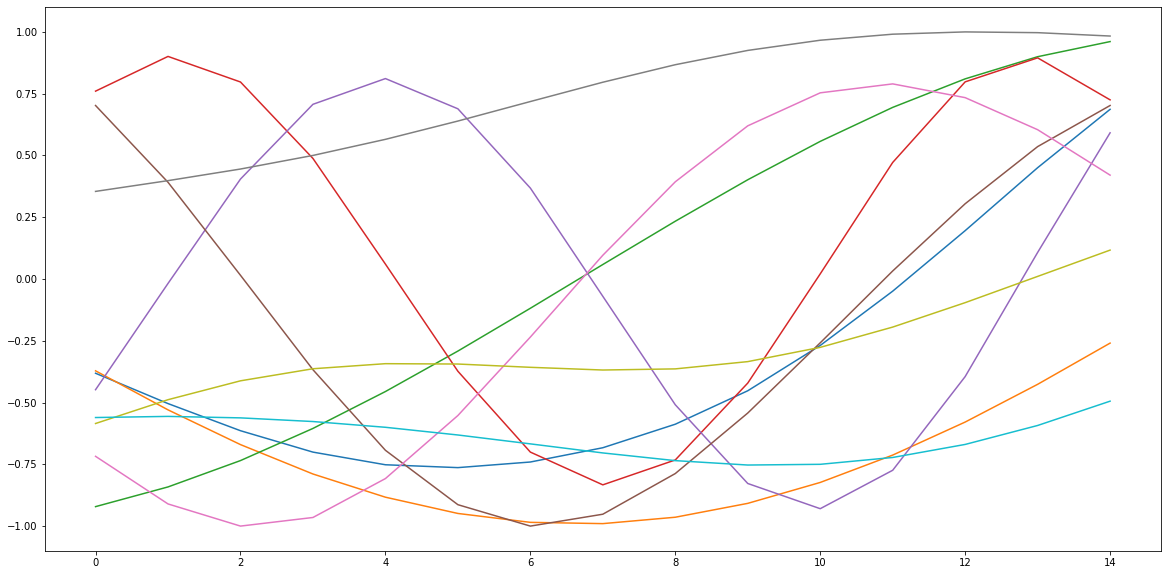

In [10]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:gan.npredictions, :])
plt.show()

fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:, :])
plt.show()

fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(csv_data[:gan.npredictions, :])
plt.show()

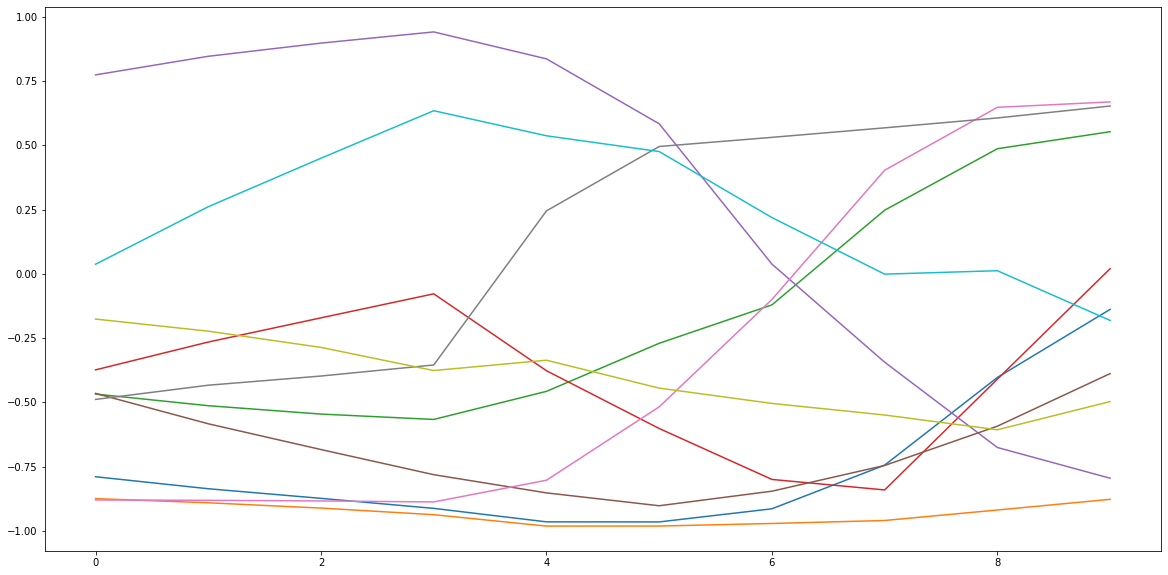

In [11]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(flds[-10:,:])
plt.show()

In [12]:
training_data.shape

(200, 100)

In [78]:
basis = np.load('../data/processed/pod_basis_field_Velocity.npy')
np.save('../data/reconstructed/velocity_field.npy', np.reshape((basis[:,:gan.ndims] @ scaling.inverse_transform((flds)).T), [1,2,221,42,-1]))

NameError: name 'scaling' is not defined

In [ ]:
scaling.inverse_transform(flds)

In [83]:
basis = np.load('../data/processed/old/pod_basis_field_Velocity.npy')

In [85]:
basis.shape

(18564, 15)

In [79]:
a = []
for i in range(8000):
    a.append(np.max(basis[i,:]))

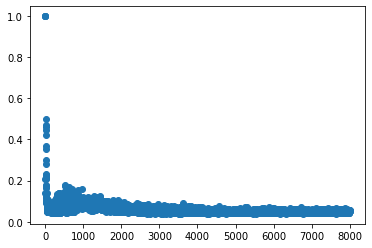

In [80]:
plt.scatter(np.arange(8000),a)

In [75]:
np.max(basis[:,1])

0.056252618285986995